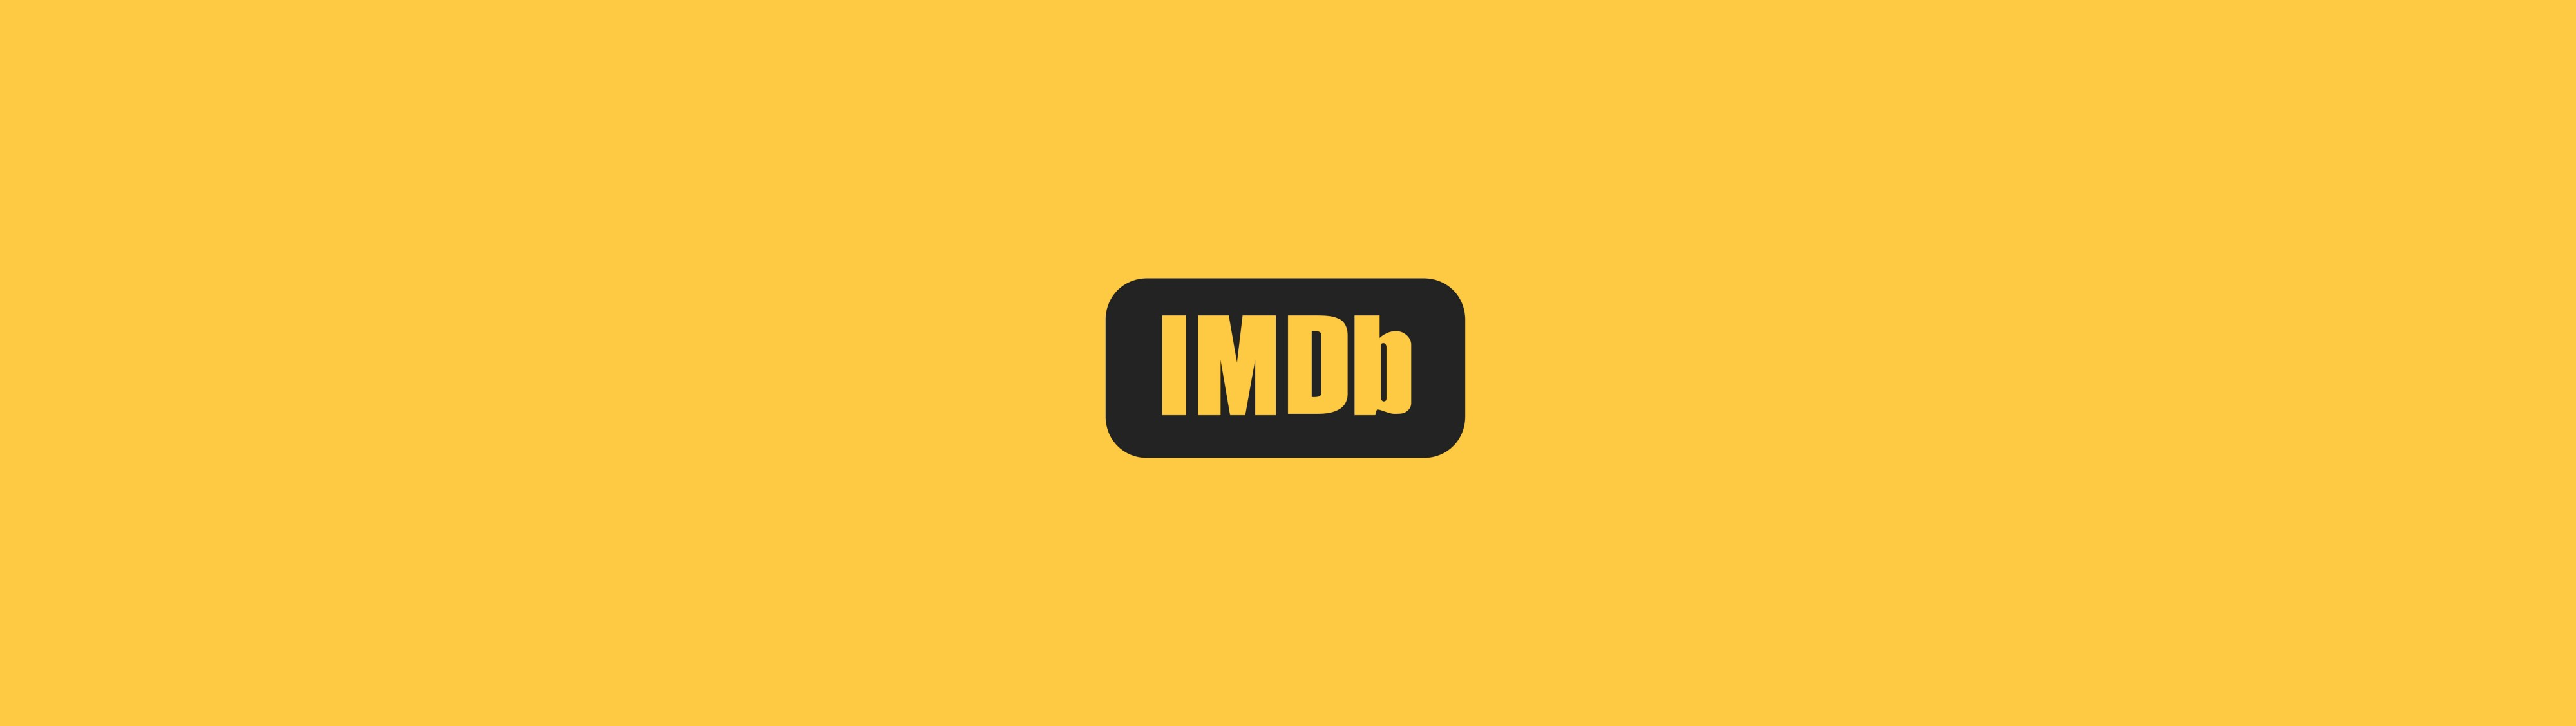
[IMDB WEBSITE](https://www.imdb.com)

# IMDb (also known as the Internet Movie Database) is an online database owned by Amazon of information related to films, television programs, home videos, video games, and streaming content online – including cast, production crew and personal biographies, plot summaries, trivia, ratings, and fan and critical reviews. An additional fan feature, message boards, was abandoned in February 2017. Originally a fan-operated website, the database is owned and operated by IMDb.com, Inc., a subsidiary of Amazon.

# As of January 2020, IMDb has approximately 6.5 million titles (including episodes) and 10.4 million personalities in its database, as well as 83 million registered users. 

# If you like, Please Upvote

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', 25)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# load dataset
movie = pd.read_csv("/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv")
credit = pd.read_csv("/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv")

In [ ]:
# first look
movie.head()

In [ ]:
credit.head()

In [ ]:
# merge two dataset
credit.columns = ['id','cast', 'title', 'crew']
movie= movie.merge(credit, on='id')

In [ ]:
movie.head(3)

In [ ]:
movie.info() # some information of dataset

In [ ]:
# Wordcolud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [ ]:
# word cloud function
def cloud(col):    
    wcloud = " ".join(f for f in movie[col])
    wc_ = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS)
    wc_.generate(wcloud)
    plt.subplots(figsize=(10,6))
    plt.imshow(wc_, interpolation="bilinear")
    plt.axis("off")

In [ ]:
# for title column
cloud("original_title")

# Content Based Filtering

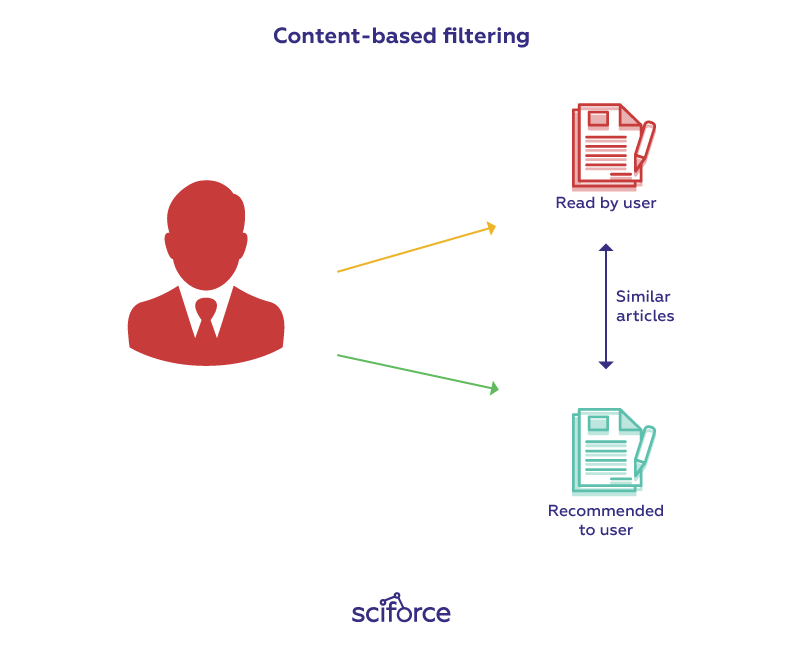

***This type of filter does not involve other users if not ourselves. Based on what we like, the algorithm will simply pick items with similar content to recommend us. In this case there will be less diversity in the recommendations, but this will work either the user rates things or not. If we compare this to the example above, maybe user B potentially likes dark comedy but he/she will never know, unless he/she decides to give it a try autonomously, because this filter will only keep recommending dystopian movies or similar. Of course there are many categories we can calculate the similarity on: in the case of movies we can decide to build our own recommender system based on genre only, or maybe we want to include director, main actors and so on.***

In [ ]:
# fill overview column
movie["overview"] = movie["overview"].fillna("")

In [ ]:
cloud("overview")

In [ ]:
# Tfidf Vectorize
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english")

tfidf_matrix = tfidf.fit_transform(movie["overview"])

tfidf_matrix

In [ ]:
# we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
# reverse map of indices and movie original_title
indices = pd.Series(movie.index, index=movie['original_title']).drop_duplicates()

In [ ]:
# recommendation function

def get_recommendation(title, cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movies = [i[0] for i in sim_scores]
    movies = movie["original_title"].iloc[movies]
    return movies

In [ ]:
# IF you search "Spectre", name of the movies below will be recommended
get_recommendation('Spectre', cosine_sim)

In [ ]:
get_recommendation("John Carter", cosine_sim)

In [ ]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['keywords', 'genres']
for feature in features:
    movie[feature] = movie[feature].apply(literal_eval)

In [ ]:
movie[['original_title', 'keywords', 'genres']].head(3)

In [ ]:
# Extract list of genres
def list_genres(x):
    l = [d['name'] for d in x]
    return(l)
movie['genres'] = movie['genres'].apply(list_genres)

# Extract list of keywords
def list_keyword(y):
    i = [a['name'] for a in y]
    return(i)
movie['keywords'] = movie['keywords'].apply(list_keyword)

In [ ]:
# join genre and keywords
def genre(x):
    return ''.join(' '.join(x['genres']) + ' ' + ' '.join(x['keywords']))

# new column
movie['mix'] = movie.apply(genre, axis=1)

In [ ]:
movie["mix"]

In [ ]:
# Countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

countvect = CountVectorizer(stop_words="english")

countvect_mat = tfidf.fit_transform(movie["mix"])

countvect_mat

# Cosine Similarity

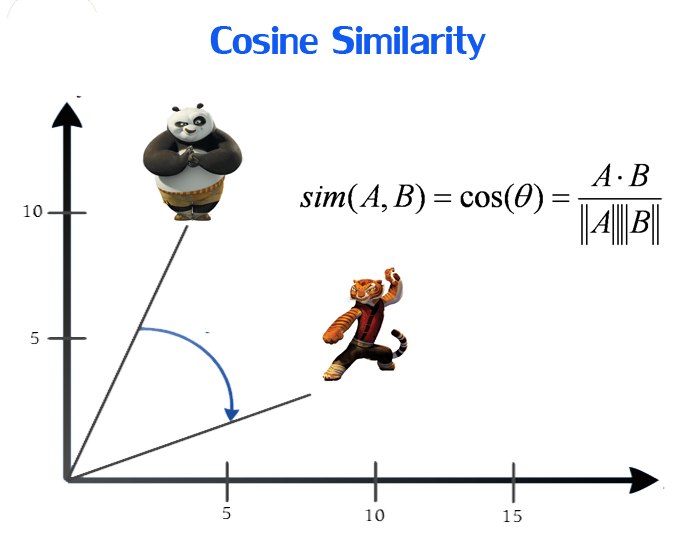

**Cosine similarity measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. It is often used to measure document similarity in text analysis.
A document can be represented by thousands of attributes, each recording the frequency of a particular word (such as a keyword) or phrase in the document. Thus, each document is an object represented by what is called a term-frequency vector.**

**We all are familiar with vectors: they can be 2D, 3D or whatever-D. Let’s think in 2D for a moment, because it’s easier to picture in our mind, and let’s refresh the concept of dot product first. The dot product between two vectors is equal to the projection of one of them on the other. Therefore, the dot product between two identical vectors (i.e. with identical components) is equal to their squared module, while if the two are perpendicular (i.e. they do not share any directions), the dot product is zero. Generally, for n-dimensional vectors, the dot product can be calculated as shown below.**

**The dot product is important when defining the similarity, as it is directly connected to it. The definition of similarity between two vectors u and v is, in fact, the ratio between their dot product and the product of their magnitudes.**

**By applying the definition of similarity, this will be in fact equal to 1 if the two vectors are identical, and it will be 0 if the two are orthogonal. In other words, the similarity is a number bounded between 0 and 1 that tells us how much the two vectors are similar.**

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(countvect_mat, countvect_mat)

In [ ]:
# reverse map of indices and movie original_title
movie = movie.reset_index()
indices = pd.Series(movie.index, index=movie['original_title'])

In [ ]:
get_recommendation("John Carter", cos_sim)

In [ ]:
get_recommendation("Soldier", cos_sim)

# Filtering Based On Vote : Demographic Filter

In [ ]:
# avarage rating
avg = movie["vote_average"].mean()
#  We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.
q = movie["vote_count"].quantile(0.9)

In [ ]:
print(avg)
print(q)

average rating is 6 out of 10

In [ ]:
movies = movie[movie["vote_count"] >= q]

# qualified movies

In [ ]:
# function of weighted_rating 
def weighted_rating(x, q=q, avg=avg):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+q) * R) + (q/(q+v) * avg)

In [ ]:
# apply for qualfied movies
movies["score"] = movies.apply(weighted_rating, axis=1)

In [ ]:
# Sort movies based on score calculated above
movies = movies.sort_values('score', ascending=False)

# Print the top 10 movies
listed = movies[['original_title', 'vote_count', 'vote_average', 'score', "popularity"]].head(10)

In [ ]:
# Visualize
import seaborn as sns


plt.subplots(figsize=(10,6))
sns.barplot(listed["score"], listed["original_title"], palette="Set2")
plt.title("Movie Vs Score")

# Trending Movies

In [ ]:
popular= movies.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(popular['original_title'].head(10),popular['popularity'].head(10), align='center',
        color="#313131")
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

# If you like, Please Upvote